# Capstone 2: Pre-processing #

This stage of the project will involve preparing the data for machine learning. This will include selecting appropriate features, imputing null values with sensible estimates, splitting the data into training and testing sets, and finally scaling the data. When imputing values and scaling the data it is important to avoid data leakage. This happens when information from the test set indirectly influences machine learning models.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import pickle as pkl

In [2]:
# Create a dataframe from the CSV file containing the analyzed data
data = pd.read_csv('analyzed_data.csv')
data.head()

,date,comuna,house,new,total_area,built_area,bedrooms,bathrooms,furnished,address,description,price_uf,days_old,zone
0,2020-09-10,Puente Alto,0,0,42.0,NaN,2.0,1.0,0,"Puente Alto, Sgto Menadier 2779","Departamento ubicado en segundo piso, en plena...",871.42,0,southeast
1,2020-09-09,Ñuñoa,0,0,70.0,NaN,2.0,2.0,0,"Ñuñoa, Irarrázaval 1401",Depto Vista despejada 2D 2B E B *2 dormitorios...,4900.00,1,east
2,2020-09-09,Santiago,0,0,23.0,NaN,1.0,1.0,0,"Santiago, Huérfanos",Oportunidad Inversionistas o particulares. Ven...,1575.00,1,center
3,2020-09-09,Las Condes,0,0,163.0,NaN,3.0,4.0,0,"Santiago, Vespucio Norte","Vespucio Norte, Las Condes, Vendo confortable ...",13500.00,1,northeast
4,2020-09-09,Ñuñoa,0,0,85.0,NaN,3.0,1.0,0,"Ñuñoa, Fidias a 3 cuadras metro Ñuble",Amplio y luminoso departamento dúplex en Villa...,3346.26,1,east


Below we select the features that we want to use in the model. In the EDA stage of the project we saw which features have strong correlations with price.  Since the columns `new`, `furnished`, and `days_old` had very weak correlations with price, these columns will not be used. We will also discard `date`, `comuna`, `address`, and `description`, making `zone` the only non-numerical column.

In [3]:
# Select the features that will be used
df = data.loc[:,['house', 'total_area', 'built_area', 'bedrooms', 'bathrooms', 'zone', 'price_uf']]
df.head()

,house,total_area,built_area,bedrooms,bathrooms,zone,price_uf
0,0,42.0,NaN,2.0,1.0,southeast,871.42
1,0,70.0,NaN,2.0,2.0,east,4900.00
2,0,23.0,NaN,1.0,1.0,center,1575.00
3,0,163.0,NaN,3.0,4.0,northeast,13500.00
4,0,85.0,NaN,3.0,1.0,east,3346.26


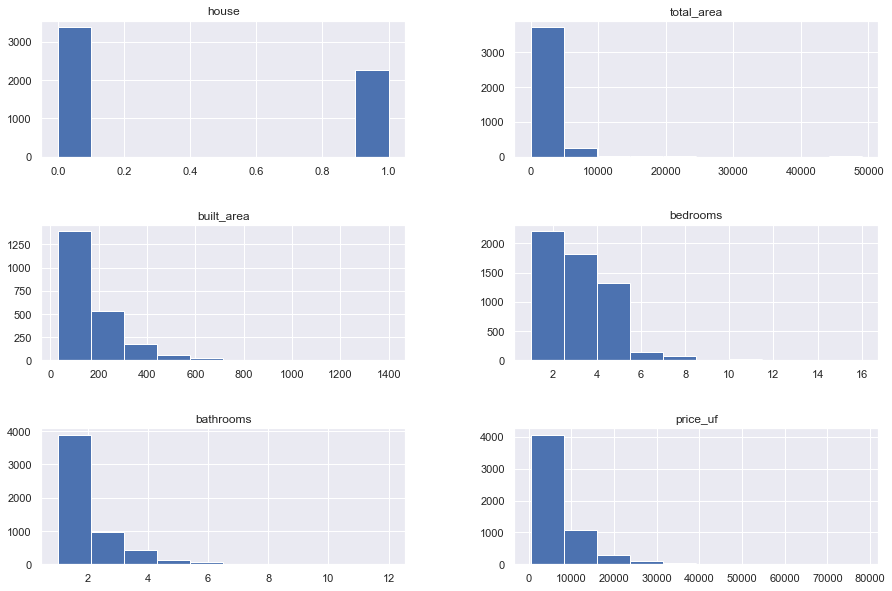

In [4]:
# Have a look at the distributions of the features
sns.set()
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

In [5]:
# See which columns are missing the most data
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
built_area,3429,60.884233
total_area,1617,28.710938
bathrooms,132,2.343750
bedrooms,29,0.514915
house,0,0.000000
zone,0,0.000000
price_uf,0,0.000000


Over 60% of the listings have null values for `built_area`. However, this is not as big of a problem as it might appear. Below we see that almost all of the listings with missing values for `built_area` are apartments. Remember that apartments only include values for `total_area`. One might argue that the sensible choice would be to drop the `built_area` column, however this column has a very high correlation with price, so we would lose potentially valuable information. If the listing is an apartment we can essentially argue that `total_area` and `built_area` are equivalent, so we will use the values for `total_area` to fill in the missing `built_area` values for apartments. This does not solve the problem of missing values in the `total_area` column, but we will deal with them later.

In [6]:
# Almost all of the missing values for built_area are for apartments
df[df['built_area'].isnull()]['house'].value_counts()

0    3382
1      47
Name: house, dtype: int64

In [7]:
# Same is true for total_area
df[df['total_area'].isnull()]['house'].value_counts()

0    1583
1      34
Name: house, dtype: int64

In [8]:
# For apartments, fill missing built_area with total_area
indices = df['house'] == 0
df.loc[indices, 'built_area'] = df.loc[indices, 'built_area'].fillna(df['total_area'])
df.head()

,house,total_area,built_area,bedrooms,bathrooms,zone,price_uf
0,0,42.0,42.0,2.0,1.0,southeast,871.42
1,0,70.0,70.0,2.0,2.0,east,4900.00
2,0,23.0,23.0,1.0,1.0,center,1575.00
3,0,163.0,163.0,3.0,4.0,northeast,13500.00
4,0,85.0,85.0,3.0,1.0,east,3346.26


In [9]:
# Drop missing values for house areas, as there are not many and they are difficult to guess
print('Rows before:', df.shape[0])
df = df[~((df.house == 1) & (df.total_area.isnull() | df.built_area.isnull()))]
print('Rows after:', df.shape[0])

Rows before: 5632
Rows after: 5551


Now we will create dummy variables for the different zones that were created in the previous stage.  A variable will be made for each zone except for 'center'. Listings in this zone will have a value of zero for all of the zones. This prevents redundancy.

In [10]:
# See the unique values for 'zone'. All but one will become a column
df['zone'].unique()

array(['southeast', 'east', 'center', 'northeast', 'north', 'south',
       'west', 'rural east', 'rural west'], dtype=object)

In [11]:
# Create dummy variables from "zone" feature
df = pd.get_dummies(df, columns=['zone'], drop_first='True', prefix='z')
df.head()

,house,total_area,built_area,bedrooms,bathrooms,price_uf,z_east,z_north,z_northeast,z_rural east,z_rural west,z_south,z_southeast,z_west
0,0,42.0,42.0,2.0,1.0,871.42,0,0,0,0,0,0,1,0
1,0,70.0,70.0,2.0,2.0,4900.00,1,0,0,0,0,0,0,0
2,0,23.0,23.0,1.0,1.0,1575.00,0,0,0,0,0,0,0,0
3,0,163.0,163.0,3.0,4.0,13500.00,0,0,1,0,0,0,0,0
4,0,85.0,85.0,3.0,1.0,3346.26,1,0,0,0,0,0,0,0


In [12]:
# See how much missing data is left
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
total_area,1583,28.517384
built_area,1583,28.517384
bathrooms,127,2.287876
bedrooms,18,0.324266
house,0,0.000000
price_uf,0,0.000000
z_east,0,0.000000
z_north,0,0.000000
z_northeast,0,0.000000
z_rural east,0,0.000000


In [13]:
# Make sure the data types are all numerical
df.dtypes

house             int64
total_area      float64
built_area      float64
bedrooms        float64
bathrooms       float64
price_uf        float64
z_east            uint8
z_north           uint8
z_northeast       uint8
z_rural east      uint8
z_rural west      uint8
z_south           uint8
z_southeast       uint8
z_west            uint8
dtype: object

Next it is time to split the data into training and test sets, and then use information from the training set to impute values in both the training and test sets.

In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price_uf'), 
                                                    df.price_uf, test_size=0.3, 
                                                    random_state=47)

In [15]:
# Check shape
X_train.shape, X_test.shape

((3885, 13), (1666, 13))

In [16]:
y_train.shape, y_test.shape

((3885,), (1666,))

Now that the data is split, it is time to deal with the missing values for `bedrooms` and `bathrooms`. In the Data Wrangling stage of the process we already dropped the rows that were missing both values, so now we can use whichever value is present to estimate the value that is missing. The cells below shows there are on average 0.78 bathrooms per bedroom in a given home, and the median numbers of bedrooms and bathrooms are 3 and 2 respectively. For each row, if the value for `bathrooms` is missing, we fill it by multiplying the value for `bedrooms` by 2/3 and rounding up to the nearest whole number. Conversely, to fill in the the missing values for `bedrooms` we will multiply the value for `bedrooms` by 3/2, and round down to the nearest integer.

In [17]:
ratio = X_train['bathrooms'] / X_train['bedrooms']
ratio.mean()

0.7767682304464522

In [18]:
# Determine typical ratio of bedrooms to bathrooms
X_train[['bedrooms', 'bathrooms']].median()

bedrooms     3.0
bathrooms    2.0
dtype: float64

In [19]:
# Use ratio to impute sensible values in training set
X_train['bathrooms'].fillna(X_train['bedrooms']*(2/3), inplace=True)
X_train['bathrooms'] = X_train['bathrooms'].apply(np.ceil).astype(int)

X_train['bedrooms'].fillna(X_train['bathrooms']*(3/2), inplace=True)
X_train['bedrooms'] = X_train['bedrooms'].astype(int)

In [20]:
# Use ratio to impute sensible values in test set
X_test['bathrooms'].fillna(X_test['bedrooms']*(2/3), inplace=True)
X_test['bathrooms'] = X_test['bathrooms'].apply(np.ceil).astype(int)

X_test['bedrooms'].fillna(X_test['bathrooms']*(3/2), inplace=True)
X_test['bedrooms'] = X_test['bedrooms'].astype(int)

In [21]:
X_train.isnull().sum()

house              0
total_area      1102
built_area      1102
bedrooms           0
bathrooms          0
z_east             0
z_north            0
z_northeast        0
z_rural east       0
z_rural west       0
z_south            0
z_southeast        0
z_west             0
dtype: int64

There are still apartments missing values for both `built_area` and `total_area`. To fill these will take the median `total_area` of apartments from the training set and use those values to fill the training and test sets.

In [22]:
# Get median area of apartments from training data
median_area = X_train[X_train['house']==0]['total_area'].median()
print(median_area)

65.0


In [23]:
# Use this to impute values for training and test sets
X_train.fillna(median_area, inplace=True)
X_test.fillna(median_area, inplace=True)

In [24]:
# Make sure there are no more null values for training set
X_train.isnull().sum()

house           0
total_area      0
built_area      0
bedrooms        0
bathrooms       0
z_east          0
z_north         0
z_northeast     0
z_rural east    0
z_rural west    0
z_south         0
z_southeast     0
z_west          0
dtype: int64

In [25]:
# Make sure there are no more null values for test set
X_test.isnull().sum()

house           0
total_area      0
built_area      0
bedrooms        0
bathrooms       0
z_east          0
z_north         0
z_northeast     0
z_rural east    0
z_rural west    0
z_south         0
z_southeast     0
z_west          0
dtype: int64

In [26]:
X_train.head()

,house,total_area,built_area,bedrooms,bathrooms,z_east,z_north,z_northeast,z_rural east,z_rural west,z_south,z_southeast,z_west
5343,1,117.0,90.0,4,2,0,0,0,0,0,0,1,0
1836,0,25.0,25.0,3,2,0,0,1,0,0,0,0,0
2499,0,103.0,103.0,4,3,0,0,1,0,0,0,0,0
30,0,45.0,45.0,2,1,0,0,0,0,0,0,0,1
2666,0,47.0,47.0,2,2,0,0,0,0,0,1,0,0


Finally, we need to scale the data, since our features are on vastly different scales. Also, some of the features are highly skewed, and most machine learning models work best with data that is more or less normally distributed. Power Transformer uses logarithmic transformation to make the data more closely resemble a normal distribution. When we fit the transformer to the data, it determines what power is optimal for each feature. We will fit the transformer to the training set and then use it to transform both the training and test sets.

In [27]:
# Create instance of PowerTransformer and fit to training set
power = PowerTransformer(copy=False)
power.fit(X_train)

PowerTransformer(copy=False)

In [28]:
# The lambda parameter shows the power of the transformation
print(power.lambdas_)

[-1.96792619e+00 -5.63253308e-01 -4.97614927e-01 -7.82278612e-03
 -5.57527347e-01 -1.06053333e+01 -2.36492116e+01 -7.33402207e+00
 -1.70345816e+01 -2.49105211e+01 -1.14289576e+01 -1.29899443e+01
 -1.81379486e+01]


In [31]:
# Transform training and test sets
X_train_scaled = power.transform(X_train)
X_test_scaled = power.transform(X_test)

In [32]:
# Outputs are numpy arrays, so change them back to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)
X_train_scaled.head()

,house,total_area,built_area,bedrooms,bathrooms,z_east,z_north,z_northeast,z_rural east,z_rural west,z_south,z_southeast,z_west
0,1.251419,0.194465,0.139287,0.847021,0.087006,-0.39572,-0.254886,-0.485071,-0.30417,-0.247942,-0.379464,2.830887,-0.293955
1,-0.799093,-2.535776,-2.865874,0.198918,0.087006,-0.39572,-0.254886,2.061553,-0.30417,-0.247942,-0.379464,-0.353246,-0.293955
2,-0.799093,0.044724,0.362569,0.847021,0.908910,-0.39572,-0.254886,2.061553,-0.30417,-0.247942,-0.379464,-0.353246,-0.293955
3,-0.799093,-1.227193,-1.264642,-0.638303,-1.319808,-0.39572,-0.254886,-0.485071,-0.30417,-0.247942,-0.379464,-0.353246,3.401884
4,-0.799093,-1.145409,-1.162440,-0.638303,0.087006,-0.39572,-0.254886,-0.485071,-0.30417,-0.247942,2.635296,-0.353246,-0.293955


Below are histograms of the original and scaled data showing how the distributions have shifted. The distributions of the binary columns look the same as before, although the values have been changed.

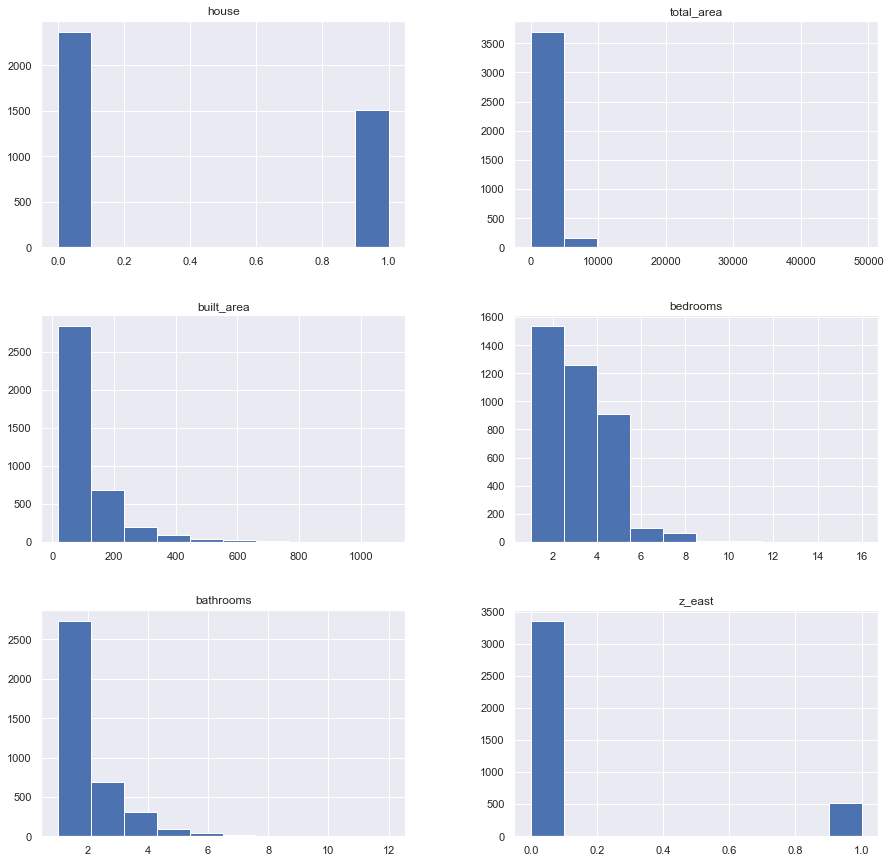

In [33]:
# Original distributions before scaling, including one of the dummy vaiables
X_train[['house', 'total_area', 'built_area', 'bedrooms', 'bathrooms', 'z_east']].hist(figsize=(15, 15));

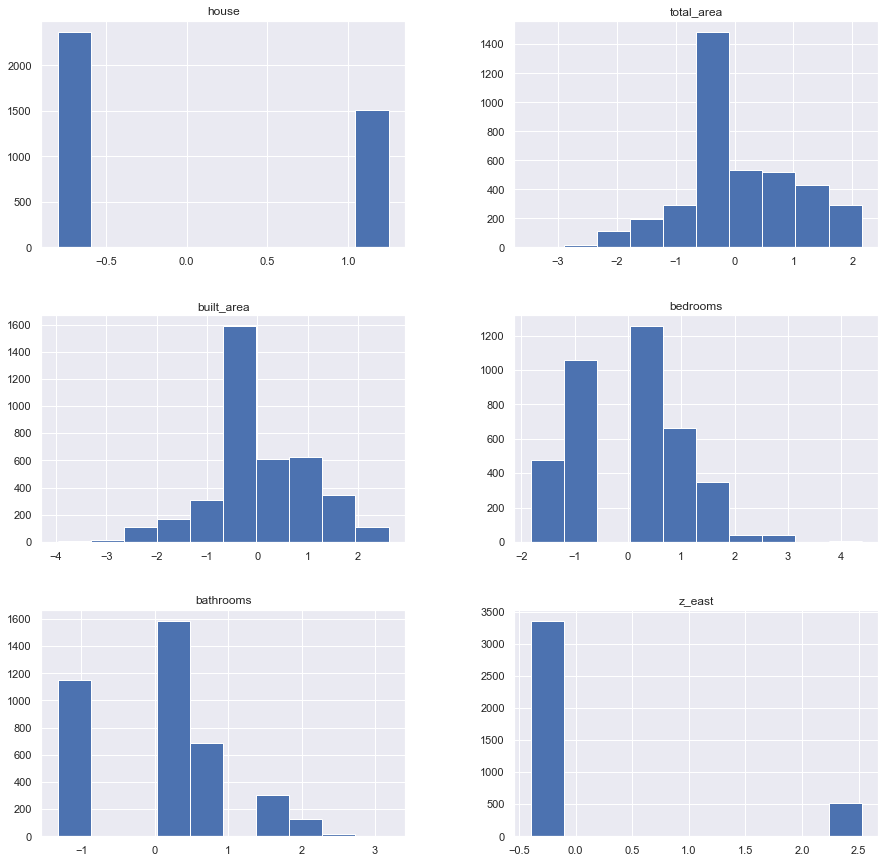

In [34]:
# Distributions after scaling, including one dummy variable
X_train_scaled[['house', 'total_area', 'built_area', 'bedrooms', 'bathrooms', 'z_east']].hist(figsize=(15, 15));

In [35]:
# Save results to pickle files, including unscaled data
with open('train.pkl', 'wb') as file:
    pkl.dump([X_train, X_train_scaled, y_train], file)

with open('test.pkl', 'wb') as file:
    pkl.dump([X_test, X_test_sclaled, y_test], file)